In [201]:
import os
import mlflow

mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
from mlflow.models import infer_signature

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('future.no_silent_downcasting', True)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MaxAbsScaler
from mlflow import log_metric, log_param, log_artifacts

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
import itertools

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input director

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [202]:
data = pd.read_csv("data/marketing_campaign.csv", sep="\t")
print("Number of datapoints:", len(data))
data.head()

Number of datapoints: 2240


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [203]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

Income has Null values - Delete these coloumns

In [204]:
index_to_drop = data['Income'].idxmax()
print(data.iloc[index_to_drop])
# Drop the row with the highest income
data.drop(index_to_drop, inplace=True)

ID                           9432
Year_Birth                   1977
Education              Graduation
Marital_Status           Together
Income                   666666.0
Kidhome                         1
Teenhome                        0
Dt_Customer            02-06-2013
Recency                        23
MntWines                        9
MntFruits                      14
MntMeatProducts                18
MntFishProducts                 8
MntSweetProducts                1
MntGoldProds                   12
NumDealsPurchases               4
NumWebPurchases                 3
NumCatalogPurchases             1
NumStorePurchases               3
NumWebVisitsMonth               6
AcceptedCmp3                    0
AcceptedCmp4                    0
AcceptedCmp5                    0
AcceptedCmp1                    0
AcceptedCmp2                    0
Complain                        0
Z_CostContact                   3
Z_Revenue                      11
Response                        0
Name: 2233, dt

In [205]:
print("Total categories in the feature Marital_Status:\n", data["Marital_Status"].value_counts(), "\n")
print("Total categories in the feature Education:\n", data["Education"].value_counts())

Total categories in the feature Marital_Status:
 Marital_Status
Married     864
Together    579
Single      480
Divorced    232
Widow        77
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64 

Total categories in the feature Education:
 Education
Graduation    1126
PhD            486
Master         370
2n Cycle       203
Basic           54
Name: count, dtype: int64


**Data Cleaning**

In [206]:
# Check for duplicates
duplicates = data.duplicated()
# Show the duplicated rows
print(len(data[duplicates]))

0


In [207]:
#Drop NAN Values in Income
data = data.dropna()
data = data.dropna(subset=['Income'])

In [208]:
# Drop rows with none sense input in Marital_Status
indices_yolo = data[data['Marital_Status'] == 'YOLO'].index
data = data.drop(indices_yolo)
indices_absurd = data[data['Marital_Status'] == 'Absurd'].index
data = data.drop(indices_absurd)

**Data Preprocessing**

In [209]:
index_recency = data['Recency'].idxmax()

#Coloumns to Preprocess:
*  Martial_Status (Marek)
*  Education (Marek)
*  Year_Birth (last enrollment date) (Felix)


#Encoding Object Coloumns: (Marek)

#Scaling Features (Felix)

#Feature Engineering
* Living Alone/Living With someone - boolean (Felix)
* Total Amount Spent (Marek)



In [210]:
def get_unique(dataframe):
  for column in df.columns:
    unique_count = df[column].nunique()
    print(f"Number of unique values in column '{column}': {unique_count}")

In [211]:
data['Dt_Customer'] = pd.to_datetime(data['Dt_Customer'], format='%d-%m-%Y')
latest_date = data['Dt_Customer'].max()
print(latest_date)

2014-06-29 00:00:00


In [212]:
#Preprocessing Dt_Customer to numerical format
data['Dt_Customer'] = data['Dt_Customer'].apply(lambda x: x.toordinal())

In [213]:
# Preprocessing Year_Birth
#The Year 2014 is the last included in the dataset -> we choose 2015 as base year
data['Age']=2015-data['Year_Birth']

In [214]:
indices_age = data[data['Age'] > 90].index
data = data.drop(indices_age)

In [215]:
# Create numeric variables for categorical variables and summarize categories.
data["Marital_Categories"] = data["Marital_Status"].replace({"Single":0, "Alone":0, "Together":1, "Married":1, "Divorced":0, "Widow":0})
data["Edu_Categories"] = data["Education"].replace({"Basic":0, "2n Cycle":2, "Graduation":1, "Master":2, "PhD":3})

In [216]:
# Summarize the amount spent on all products.
data["Spent_Total"] = data["MntWines"] + data["MntFruits"] + data["MntMeatProducts"] + data["MntFishProducts"] + data["MntSweetProducts"] + data["MntGoldProds"]

In [217]:
#creating feature "Living_Alone" as boolean
data['Living_Alone'] = data['Marital_Status'].replace({"Married":1, "Together":1, "Absurd":0, "Widow":0, "YOLO":0, "Divorced":0, "Single":0, "Alone":0})
data['Living_Alone'] = data['Living_Alone'] + data['Kidhome'] + data['Teenhome']
data['Living_Alone'] = data['Living_Alone'].where(data['Living_Alone'] <= 1, 1)
print(data['Living_Alone'].unique())

[0 1]


In [218]:
data['Having_Kids'] = data['Kidhome'] + data['Teenhome']
data['Having_Kids'] = data['Having_Kids'].where(data['Having_Kids'] <= 1, 1)

In [219]:
data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,Complain,Z_CostContact,Z_Revenue,Response,Age,Marital_Categories,Edu_Categories,Spent_Total,Living_Alone,Having_Kids
0,5524,1957,Graduation,Single,58138.0,0,0,734750,58,635,...,0,3,11,1,58,0,1,1617,0,0
1,2174,1954,Graduation,Single,46344.0,1,1,735300,38,11,...,0,3,11,0,61,0,1,27,1,1
2,4141,1965,Graduation,Together,71613.0,0,0,735101,26,426,...,0,3,11,0,50,1,1,776,1,0
3,6182,1984,Graduation,Together,26646.0,1,0,735274,26,11,...,0,3,11,0,31,1,1,53,1,1
4,5324,1981,PhD,Married,58293.0,1,0,735252,94,173,...,0,3,11,0,34,1,3,422,1,1


In [220]:
for column in data.columns:
    unique_count = data[column].nunique()
    print(f"Number of unique values in column '{column}': {unique_count}")

Number of unique values in column 'ID': 2208
Number of unique values in column 'Year_Birth': 56
Number of unique values in column 'Education': 5
Number of unique values in column 'Marital_Status': 6
Number of unique values in column 'Income': 1969
Number of unique values in column 'Kidhome': 3
Number of unique values in column 'Teenhome': 3
Number of unique values in column 'Dt_Customer': 662
Number of unique values in column 'Recency': 100
Number of unique values in column 'MntWines': 775
Number of unique values in column 'MntFruits': 158
Number of unique values in column 'MntMeatProducts': 553
Number of unique values in column 'MntFishProducts': 182
Number of unique values in column 'MntSweetProducts': 176
Number of unique values in column 'MntGoldProds': 211
Number of unique values in column 'NumDealsPurchases': 15
Number of unique values in column 'NumWebPurchases': 15
Number of unique values in column 'NumCatalogPurchases': 14
Number of unique values in column 'NumStorePurchases':

'Z_CostContact' & Z_Revenue' only have one value, so we can drop the columns.

In [221]:
columns_to_drop = ['Z_CostContact', 'Z_Revenue']
data = data.drop(columns=columns_to_drop)

#Drop redundant features

In [222]:
#Year_Birth and Age are redundant
#Education and Edu_Categories are redundant
#We will use Kids_Home instead of TeenHome and Kidhome
#Living_Alone instead of Marital_Status 
columns_to_drop = ['Year_Birth', 'Education', 'Kidhome', 'Teenhome', 'Marital_Status']
data = data.drop(columns=columns_to_drop)

In [223]:
#Scaling
max_abs_scaler = MaxAbsScaler()
data_maxabs = max_abs_scaler.fit_transform(data)

In [224]:
def print_first_rows(arr, num_rows):
  """Prints the first n rows of a NumPy array."""
  if num_rows > arr.shape[0]:
    print(f"Number of rows ({num_rows}) exceeds the array's total rows ({arr.shape[0]})")
  else:
    print(arr[:num_rows])

In [225]:
print_first_rows(data_maxabs, 5)

[[0.49361094 0.35799922 0.99909847 0.58585859 0.42531815 0.44221106
  0.31652174 0.66409266 0.33587786 0.2741433  0.2        0.2962963
  0.35714286 0.30769231 0.35       0.         0.         0.
  0.         0.         0.         1.         0.77333333 0.
  0.33333333 0.64039604 0.         0.        ]
 [0.19426325 0.28537473 0.99984634 0.38383838 0.00736772 0.00502513
  0.00347826 0.00772201 0.00381679 0.01869159 0.13333333 0.03703704
  0.03571429 0.15384615 0.25       0.         0.         0.
  0.         0.         0.         0.         0.81333333 0.
  0.33333333 0.01069307 1.         1.        ]
 [0.37002949 0.44097489 0.99957575 0.26262626 0.28533155 0.24623116
  0.07362319 0.42857143 0.08015267 0.13084112 0.06666667 0.2962963
  0.07142857 0.76923077 0.2        0.         0.         0.
  0.         0.         0.         0.         0.66666667 1.
  0.33333333 0.30732673 1.         0.        ]
 [0.55240819 0.16407939 0.99981099 0.26262626 0.00736772 0.0201005
  0.0115942  0.03861004 0.

#Evaluation of Model
* sklearn.metrics.silhouette_score
* sklearn.metrics.calinski_harabasz_score
* mean_squared_error




# Building the Model
* KMeans
* DBSCAN

In [226]:
from sklearn.cluster import KMeans

Elbow Method to determine the number of clusters to be formed:


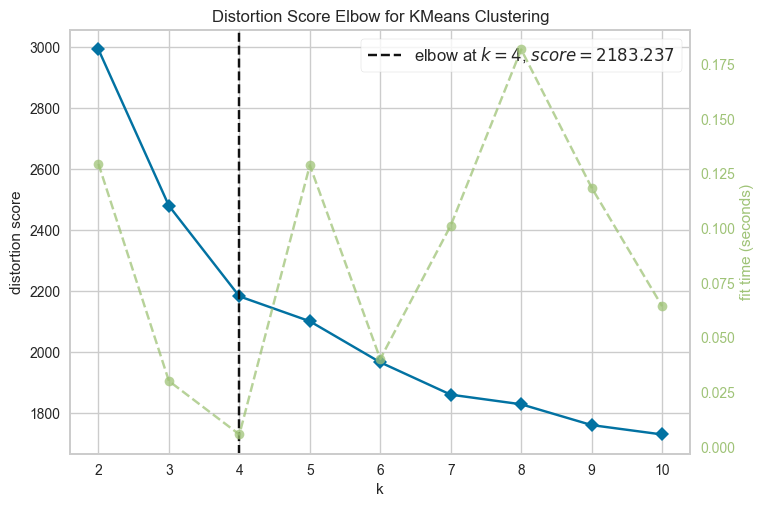

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [227]:
from yellowbrick.cluster import KElbowVisualizer
print('Elbow Method to determine the number of clusters to be formed:')
data_maxabs = data_maxabs[~np.isnan(data_maxabs).any(axis=1), :]
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(data_maxabs)
Elbow_M.show()

In [228]:
def plot_k_distance(data, min_samples):
    neighbors = NearestNeighbors(n_neighbors=min_samples)
    neighbors_fit = neighbors.fit(data)
    distances, indices = neighbors_fit.kneighbors(data)
    distances = np.sort(distances[:, min_samples-1], axis=0)
    plt.plot(distances)
    plt.xlabel('Data Points sorted by distance')
    plt.ylabel(f'{min_samples}-distance')
    plt.show()

k_range = range(4, 6)

In [229]:
def evaluate_k_clustering(data, k):
    X = data
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, labels)
    davies_bouldin_avg = davies_bouldin_score(X, labels)
    return silhouette_avg, davies_bouldin_avg

In [230]:
# Function to log experiment details to MLflow for k means
def log_k_experiment(combination, k, silhouette_avg, davies_bouldin_avg):
    run_name = f"k_means k={k}_scaled"
    with mlflow.start_run(run_name=run_name):
        mlflow
        mlflow.log_param("features", combination)
        mlflow.log_param("k", k)
        mlflow.log_metric("silhouette_score", silhouette_avg)
        mlflow.log_metric("davies_bouldin_score", davies_bouldin_avg)
        mlflow.set_tag("algorithm", "KMeans")

In [61]:
# Iterate over all possible feature combinations
#for L in range(1, len(data.columns) + 1):
 #   for combination in itertools.combinations(data.columns, L):
  #      for k in k_range:
   #         silhouette_avg, davies_bouldin_avg = evaluate_clustering(data, combination, k)
    #        log_experiment(combination, k, silhouette_avg, davies_bouldin_avg)
     #       print(f"Logged {combination} with k={k}")

In [231]:
k_range = np.arange(4, 5, 1)

In [232]:
combination = data.columns

for k in k_range:
    silhouette_avg, davies_bouldin_avg = evaluate_k_clustering(data_maxabs, k)
    log_k_experiment(combination, k, silhouette_avg, davies_bouldin_avg)
    print(f"Logged with k={k}")

Logged with k=4


In [233]:
print("Clustering evaluation completed and logged to MLflow.")

Clustering evaluation completed and logged to MLflow.


In [234]:
def plot_cardinality_cluster_kmeans(data, k):
    X = data
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    unique_labels = set(labels)
    if len(unique_labels) > 1:
        n_clusters = len(set(labels)) 
        n_noise = list(labels).count(-1)    
    
    cardinality = [list(labels).count(label) for label in unique_labels]
    clusters = ['Noise' if label == -1 else f'Cluster {label}' for label in unique_labels]
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=clusters, y=cardinality)
    plt.title('Cardinality of Each Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Number of Points')
    plt.show()

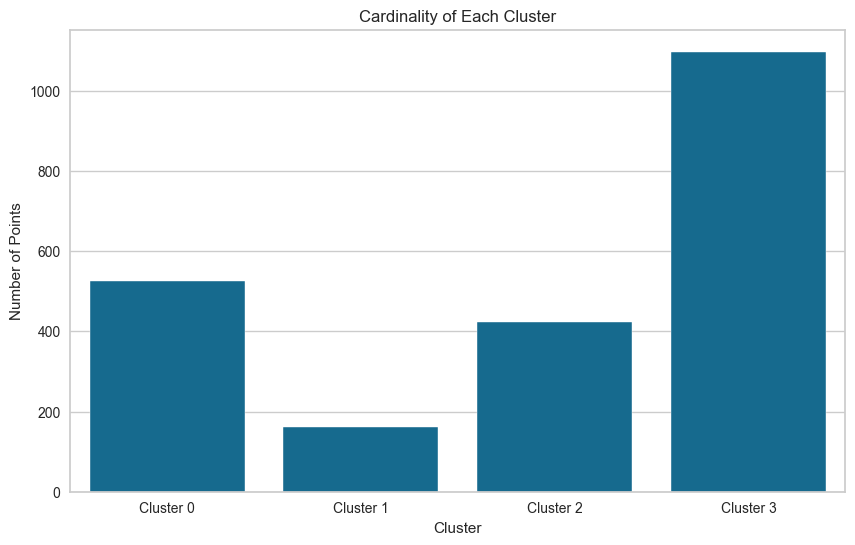

In [236]:
plot_cardinality_cluster_kmeans(data_maxabs, 4)

In [237]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
data['Cluster'] = kmeans.fit_predict(data_maxabs)
clusters = data['Cluster'].unique()

In [238]:
cluster_dfs = {}
for cluster in clusters:
    cluster_dfs[cluster] = data[data['Cluster'] == cluster].reset_index(drop=True)

In [239]:
cluster_0_df = cluster_dfs[0]
cluster_1_df = cluster_dfs[1]
cluster_2_df = cluster_dfs[2]
cluster_3_df = cluster_dfs[3]

In [241]:
for column in cluster_0_df.columns:
    unique_count = cluster_0_df[column].nunique()
    print(f"Number of unique values in column '{column}': {unique_count}")

Number of unique values in column 'ID': 525
Number of unique values in column 'Income': 479
Number of unique values in column 'Dt_Customer': 344
Number of unique values in column 'Recency': 100
Number of unique values in column 'MntWines': 274
Number of unique values in column 'MntFruits': 79
Number of unique values in column 'MntMeatProducts': 186
Number of unique values in column 'MntFishProducts': 81
Number of unique values in column 'MntSweetProducts': 81
Number of unique values in column 'MntGoldProds': 123
Number of unique values in column 'NumDealsPurchases': 12
Number of unique values in column 'NumWebPurchases': 13
Number of unique values in column 'NumCatalogPurchases': 12
Number of unique values in column 'NumStorePurchases': 14
Number of unique values in column 'NumWebVisitsMonth': 12
Number of unique values in column 'AcceptedCmp3': 2
Number of unique values in column 'AcceptedCmp4': 2
Number of unique values in column 'AcceptedCmp5': 2
Number of unique values in column 'A

In [242]:
income_medians = {
    'Cluster 0': cluster_0_df['Income'].median(),
    'Cluster 1': cluster_1_df['Income'].median(),
    'Cluster 2': cluster_2_df['Income'].median(),
    'Cluster 3': cluster_3_df['Income'].median()
}
age_medians = {
    'Cluster 0': cluster_0_df['Age'].median(),
    'Cluster 1': cluster_1_df['Age'].median(),
    'Cluster 2': cluster_2_df['Age'].median(),
    'Cluster 3': cluster_3_df['Age'].median()
}

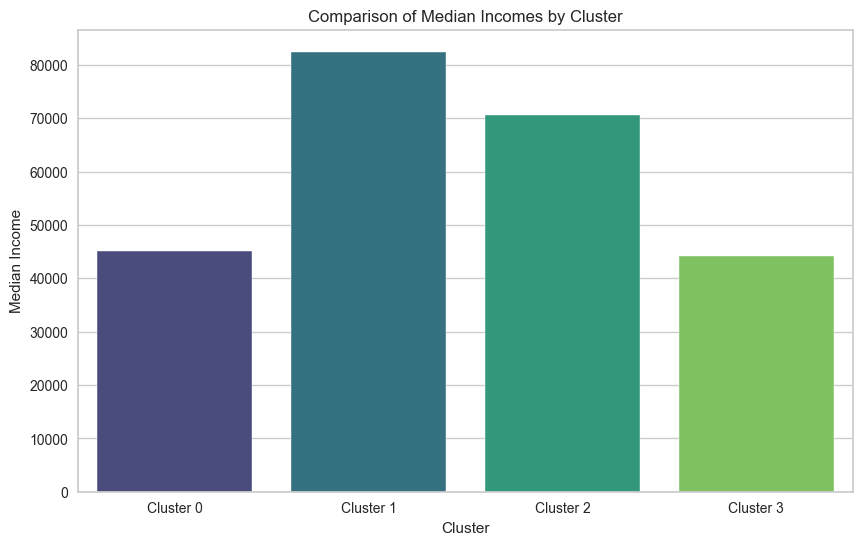

In [243]:
income_medians_df = pd.DataFrame(list(income_medians.items()), columns=['Cluster', 'Median Income'])

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='Median Income', data=income_medians_df, palette='viridis', hue='Cluster', legend=False)
plt.title('Comparison of Median Incomes by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Median Income')
plt.show()

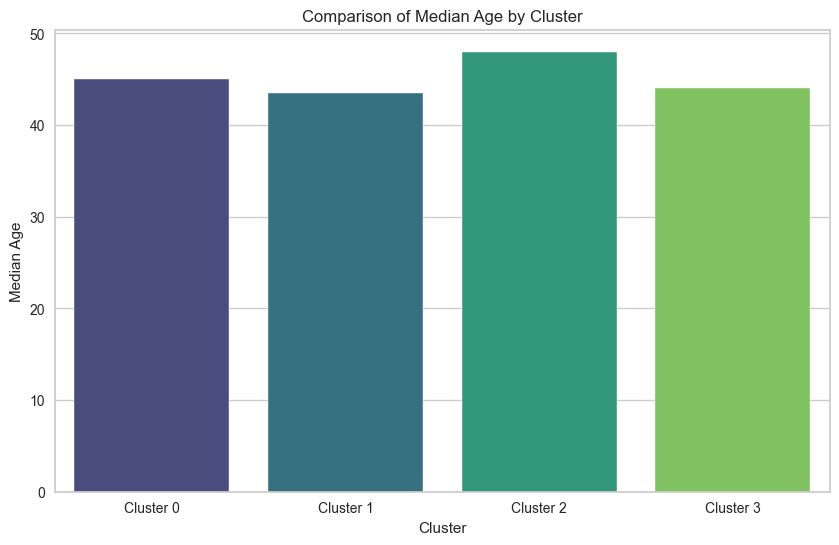

In [244]:
age_medians_df = pd.DataFrame(list(age_medians.items()), columns=['Cluster', 'Median Age'])

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='Median Age', data=age_medians_df, palette='viridis', hue='Cluster', legend=False)
plt.title('Comparison of Median Age by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Median Age')
plt.show()

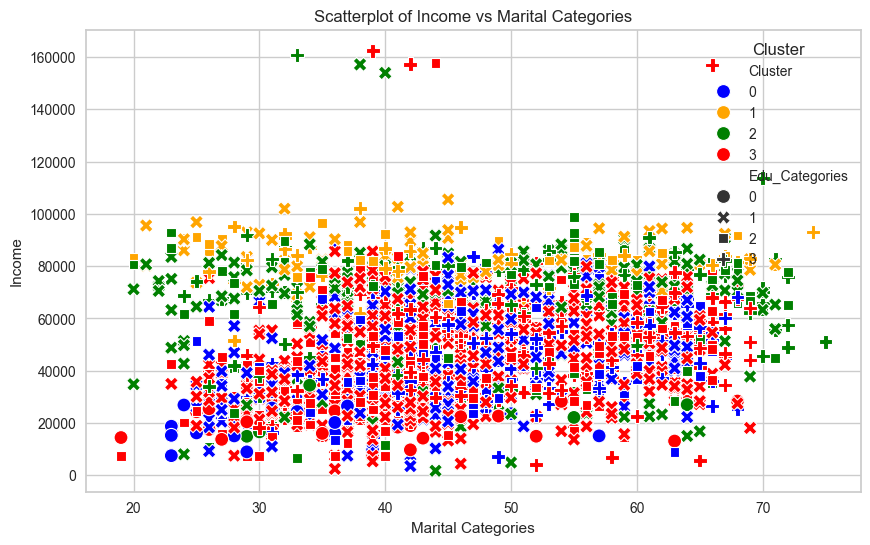

In [247]:
palette = {0: 'blue', 1: 'orange', 2: 'green', 3: 'red'}
# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Age', y='Income', hue='Cluster',  style='Edu_Categories', data=data, palette=palette, s=100)
plt.title('Scatterplot of Income vs Marital Categories')
plt.xlabel('Marital Categories')
plt.ylabel('Income')
plt.legend(title='Cluster')

plt.show()

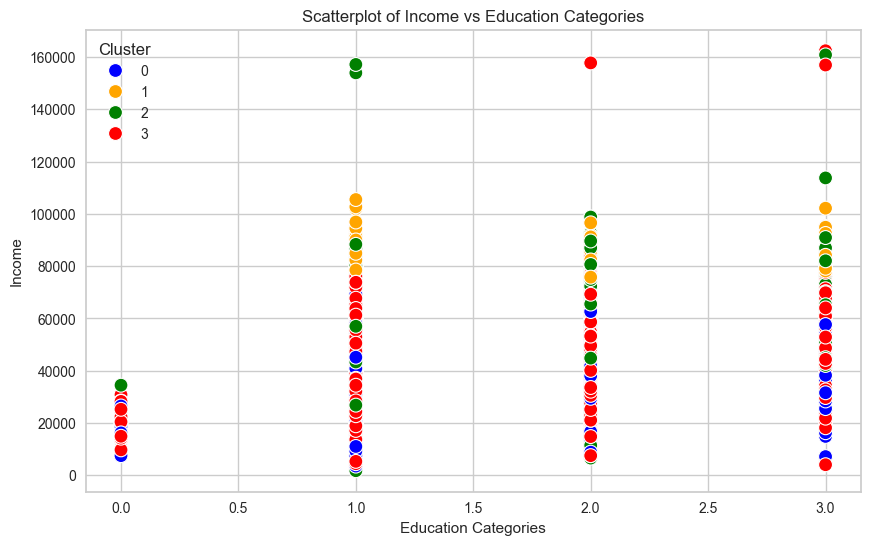

In [246]:
palette = {0: 'blue', 1: 'orange', 2: 'green', 3: 'red'}
# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Edu_Categories', y='Income', hue='Cluster', data=data, palette=palette, s=100)
plt.title('Scatterplot of Income vs Education Categories')
plt.xlabel('Education Categories')
plt.ylabel('Income')
plt.legend(title='Cluster')

plt.show()

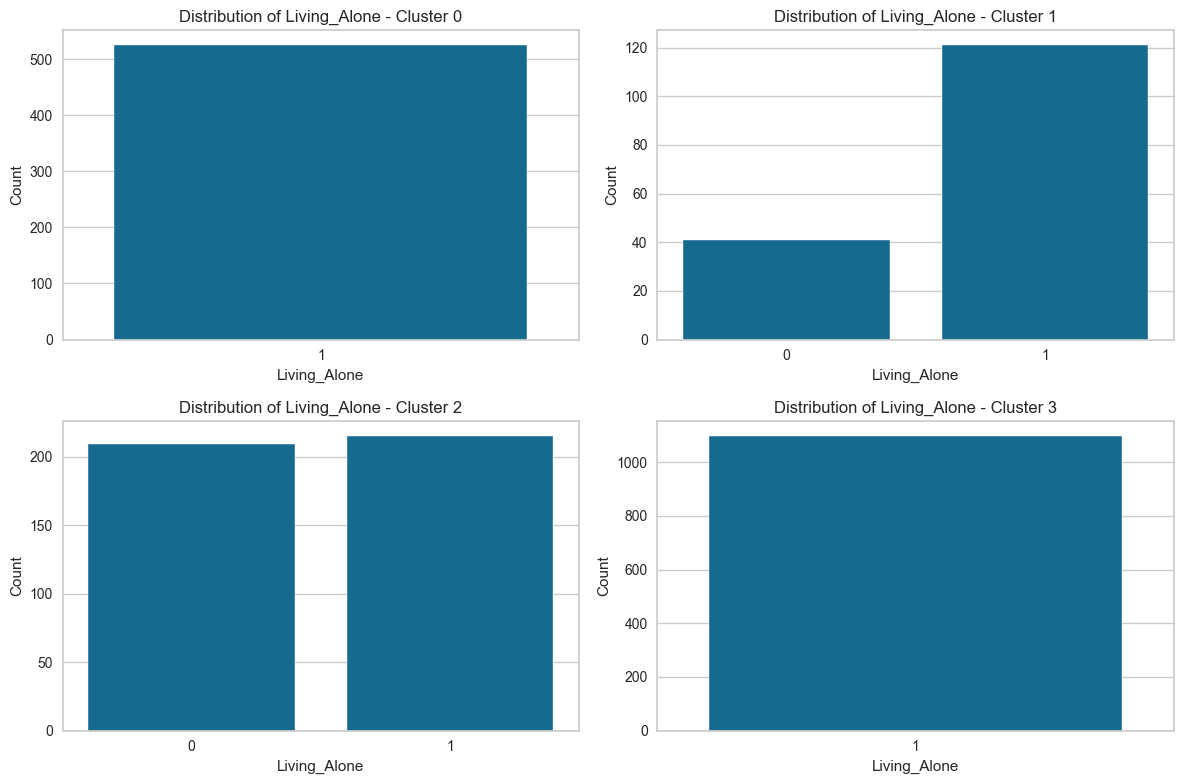

In [251]:
# Plotting
plt.figure(figsize=(12, 8))

# Iterate through each dataframe
for i, df in enumerate([cluster_0_df, cluster_1_df, cluster_2_df, cluster_3_df]):
    plt.subplot(2, 2, i + 1)  # Create subplot for each dataframe
    sns.countplot(x='Living_Alone', data=df)
    plt.title(f'Distribution of Living_Alone - Cluster {i}')
    plt.xlabel('Living_Alone')
    plt.ylabel('Count')

plt.tight_layout()
plt.show()


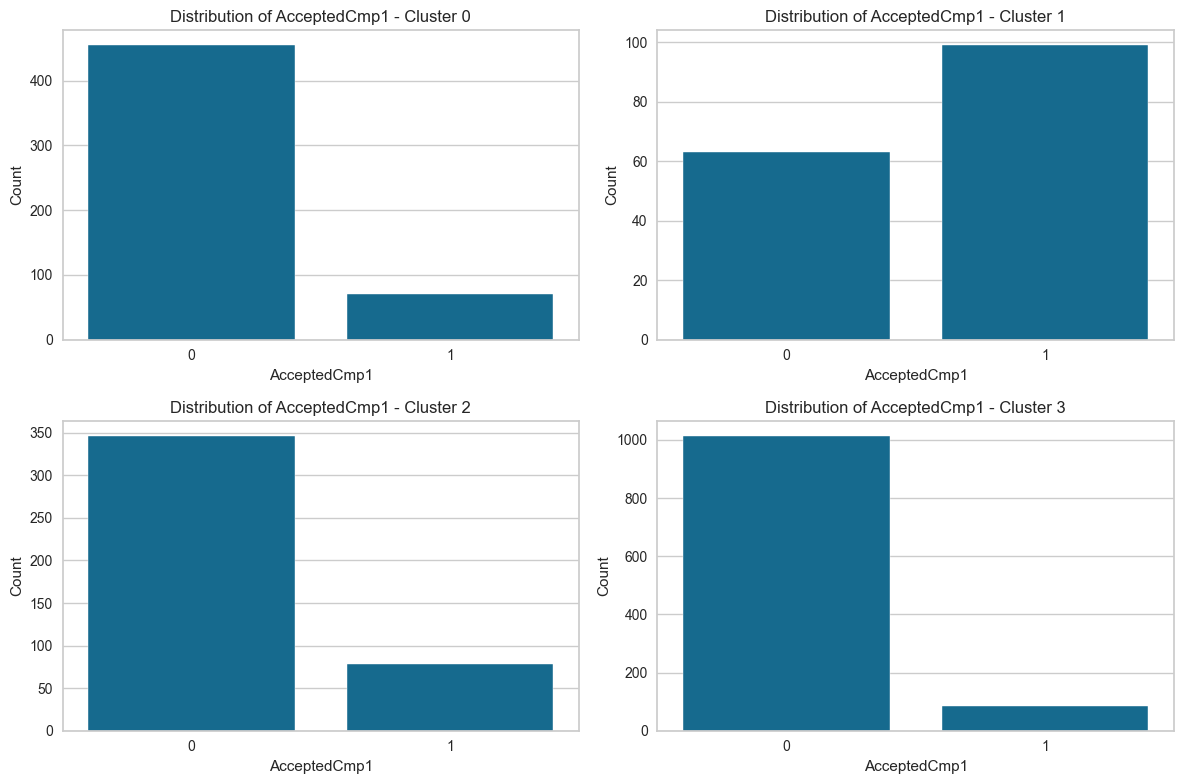

In [257]:
# Plotting
plt.figure(figsize=(12, 8))

# Iterate through each dataframe
for i, df in enumerate([cluster_0_df, cluster_1_df, cluster_2_df, cluster_3_df]):
    plt.subplot(2, 2, i + 1)  # Create subplot for each dataframe
    sns.countplot(x='Response', data=df)
    plt.title(f'Distribution of AcceptedCmp1 - Cluster {i}')
    plt.xlabel('AcceptedCmp1')
    plt.ylabel('Count')

plt.tight_layout()
plt.show()